In [256]:
!which python
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [262]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np

import matplotlib.pyplot as plt

import utils
from utils import moving_average
from solve_binary_libsvm import solve_binary_libsvm
from loss_functions import LogisticRegressionLoss, BaseOracle
from methods import *

import sklearn
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split

import scipy
import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [164]:
import sklearn.model_selection


np.random.seed(0)
n = 5_000
d = 100
dataset_name = "synthetic-interpolation"

data, target = sklearn.datasets.make_classification(n_samples=n, n_features=d, n_redundant=0, n_clusters_per_class=1, class_sep=3.0, random_state=0)
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target, test_size=0.2, random_state=0)

train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])

L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T @ train_data, ord=2)

# batch_size = train_data.shape[0]
batch_size = 100

print(f"{L=}")
print(f"{1/L=}")
print(f"{np.unique(train_target)=}")

oracle = LogisticRegressionLoss()
w = np.random.randn(train_data.shape[1])
train_result = scipy.optimize.minimize(
        fun=oracle.func,
        jac=oracle.grad,
        x0=w,
        args=(train_data, train_target),
        method="L-BFGS-B"
    )

test_result = scipy.optimize.minimize(
    fun=oracle.func,
    jac=oracle.grad,
    x0=w,
    args=(test_data, test_target),
    method="L-BFGS-B"
)
    
b = {
    "dataset_name": dataset_name,
    "train/f_star": oracle.func(train_result.x, train_data, train_target),
    "test/f_star": oracle.func(test_result.x, test_data, test_target),
    "train/x_star": train_result.x,
    "test/x_star": test_result.x
}

    
train_f_star, train_x_star, test_f_star, test_x_star = b["train/f_star"], b["train/x_star"], b["test/f_star"], b["test/x_star"]
print(f"{train_f_star=}")
print(f"{test_f_star=}")

dataset = train_data, train_target, test_data, test_target

L=2.4476005045688796
1/L=0.40856340654176326
np.unique(train_target)=array([-1.,  1.])
train_f_star=0.013058385251705279
test_f_star=3.7758441795178194e-06


In [125]:
np.random.seed(0)
n = 2000
d = 100
dataset_name = "synthetic-no-interpolation"

data, target = sklearn.datasets.make_classification(n_samples=n, n_features=d, n_redundant=0, n_clusters_per_class=2, class_sep=0.1, random_state=0)
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target, test_size=0.2, random_state=0)

train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])


L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T.dot(train_data), ord=2)

# batch_size = train_data.shape[0]
batch_size = 100

print(f"{L=}")
print(f"{1/L=}")
print(f"{np.unique(train_target)=}")

dataset = train_data, train_target, test_data, test_target

L=0.3813798712150801
1/L=2.622057626727887
np.unique(train_target)=array([-1.,  1.])


In [263]:
dataset_name = "a1a"
trainX, trainY, testX, testY = utils.get_libsvm(dataset_name, test_split=0.0)

trainY = utils.map_classes_to(trainY, [-1.0, 1.0])
testY = utils.map_classes_to(testY, [-1.0, 1.0])

train_data, train_target = sklearn.preprocessing.normalize(trainX, norm='l2', axis=1), trainY
test_data, test_target = sklearn.preprocessing.normalize(testX, norm='l2', axis=1), testY

b = solve_binary_libsvm(train_data, train_target, test_data, test_target)
train_f_star, train_x_star, test_f_star, test_x_star = b["train/f_star"], b["train/x_star"], b["test/f_star"], b["test/x_star"]

L = (0.25 / train_data.shape[0]) * scipy.sparse.linalg.norm(train_data.T @ train_data, ord=2)

dataset = train_data, train_target, test_data, test_target

# batch_size = train_data.shape[0]
batch_size = 64
setting = "Deterministic" if batch_size == train_data.shape[0] else "Stochastic"

print(f"{train_f_star=}")
print(f"{test_f_star=}")
print(f"{1/L=}")
print(f"{batch_size=}")
print(f"{train_data.shape=}, {test_data.shape=}")
print(f"{np.unique(train_target)=}, {np.unique(test_target)=}")

train_f_star=0.297936097212494
test_f_star=0.3219463258080662
1/L=8.85270283868551
batch_size=64
train_data.shape=(1605, 123), test_data.shape=(30956, 123)
np.unique(train_target)=array([-1.,  1.]), np.unique(test_target)=array([-1.,  1.])


In [264]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markeredgecolor=None, markersize=8,
            alphas=None, f_star=None, suptitle=None, prefix="train",
            x_labels=None, y_labels=None,
            threshold=1e-10, xlims=None, apply_ma=True,
            tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
    
    if alphas is None:
        alphas = [1.0 for x in histories]

    ma_factor = lambda x: x // 20 if apply_ma else 0
        
    for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):
        if not f_star:
            f_suboptim = history[f"{prefix}/loss"]
        else:
            f_suboptim = history[f"{prefix}/loss"] - f_star
        
        f_suboptim = moving_average(f_suboptim, ma_factor(len(f_suboptim)))

        try:
            markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(history[f"{prefix}/loss"]) - 5, len(history[f"{prefix}/loss"]) // 10)]
        except:
            markevery = []
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        res = history[f"{prefix}/grad_norm_sq"]
        res = moving_average(res, ma_factor(len(res)))
        ax[1].semilogy(res, linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        ax[2].plot(history[f"test/acc"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        try:
            markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(history["lr"]) - 5, len(history["lr"]) // 5)]
        except:
            markevery = []
        
        res = history["lr"]
        res = moving_average(res, ma_factor(len(res)))
        if alpha != 1.0:
            ax[3].semilogy(res, linestyle=ls, linewidth=lw, color=c, alpha=alpha)
            ax[3].semilogy(moving_average(res, ma_factor(len(f_suboptim))), linestyle=ls, linewidth=lw, color=c, alpha=1.0, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        else:
            ax[3].semilogy(res, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

    if f_star == 0.0:
        ax[0].set_ylabel(r"$f(x_k)$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
    else:
        ax[0].set_ylabel(r"$f(x_k) - f^*$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
        
    ax[2].set_ylabel("Test Accuracy")
    ax[3].set_ylabel("step-size")
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[2].set_xlabel("Epochs")
    ax[3].set_xlabel("Steps")
    
    # ax[3].tick_params(axis='x', rotation=45)


    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])
    
    fig.legend()

    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()

In [265]:
def train_loop(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               optimizer: BaseOptimizer,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 

    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset
    
    # params = np.zeros(train_data.shape[1])
    params = np.random.randn(train_data.shape[1])
    
    optim = optimizer(params, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/acc"].append(acc)
    history["train/grad_norm_sq"].append(g_norm_sq)

    # Test Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    # batch_size = int(train_data.shape[0] * 0.9)
    
    for epoch in range(n_epochs):
        
        # Training 
        if batch_size != train_data.shape[0]: # If full batch then don't shuffle indices
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):

            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss, train_grad, train_acc = loss_function.func_grad_acc(params, batch_data, batch_target)

            if optim.__class__.__name__ == "SLS":
                def closure(params):
                    return loss_function.func(params, batch_data, batch_target)
                optim.step(loss=train_loss, grad=train_grad, closure=closure)
            else:
                optim.step(loss=train_loss, grad=train_grad)
            
            g_norm_sq = np.linalg.norm(train_grad)**2
            history["train/batch/loss"].append(train_loss)
            history["train/batch/acc"].append(train_acc)
            history["train/batch/grad_norm_sq"].append(g_norm_sq)  

            history["lr"].append(optim.lr)
            
            a = (2 * (loss - train_f_star)) / (np.square(np.linalg.norm(grad)))
            history["true_polyak"].append(a)    

        # if (epoch + 1) % 20 == 0:
        #     batch_size = int(train_data.shape[0] * 0.1)
        
        # if (epoch + 1) % 50 == 0:
        #     if optim.betas[0] < 0.8 and optim.betas[1] < 0.8:
        #         optim.betas = (optim.betas[0] + 0.2, optim.betas[1] + 0.2)
        #     else:
        #         optim.betas = (0.9, 0.9)
                
        #     print(epoch, optim.betas)

        # Train Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params, train_data, train_target)
        g_norm_sq = np.linalg.norm(grad)**2
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)
        


        # Test Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
        g_norm_sq = np.linalg.norm(grad)**2
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

In [269]:
def twin_polyak(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0,
               eps: float = 0.0,
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset

    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1])

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/acc"].append(acc)
    history["train/grad_norm_sq"].append(g_norm_sq)
    
    # Test Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)

    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            loss_y, grad_y, acc_y  = loss_function.func_grad_acc(params_y, batch_data, batch_target)
            
            lr_x = (loss_x - loss_y) / (0.5 * np.square(np.linalg.norm(grad_x)) + eps) 
            lr_y = (loss_y - loss_x) / (0.5 * np.square(np.linalg.norm(grad_y)) + eps) 
            # Optimization step
            if loss_x > loss_y:
                params_x -= lr_x * grad_x
                lr = lr_x
            else:
                params_y -= lr_y * grad_y
                lr = lr_y
            
            history["bound_c"].append( np.abs(loss_x - loss_y) / (np.maximum(loss_x, loss_y) - train_f_star))
            history["bound_d"].append( (loss_y - train_f_star) / (loss_x - train_f_star) )
            history["bound_dd"].append( (np.minimum(loss_x, loss_y) - train_f_star) / (np.maximum(loss_x, loss_y) - train_f_star) )

            history["lr_x"].append(np.abs(lr_x))
            history["lr_y"].append(np.abs(lr_y))
            history["lr"].append(lr)
            
            
        # Train Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, train_data, train_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, train_data, train_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)
            
        # Test Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, test_data, test_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

In [190]:
n_epochs = 50
seed = 0

histories = []
labels = []


hist_sgd = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=SGD,
                seed=seed, 
                lr=1/L,
                )
histories.append(hist_sgd)
if batch_size == train_data.shape[0]:
        labels.append("GD 1/L")
else:
        labels.append("SGD 1/L")
        
for eta_max in [1.0, 10.0, 100.0]:
# for eta_max in [0.0001, 0.001, 0.01, 0.1]:
        hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=SPS,
                        seed=seed,
                        eta_max=eta_max,
                        eps=0.0,
                        )
        histories.append(hist_sps)
        labels.append(r"$SPS_{{max}} \gamma={0}$".format(eta_max))
        
hist_sls = train_loop(
        dataset=dataset,
        batch_size=batch_size,
        n_epochs=n_epochs,
        optimizer=SLS,
        seed=seed
        )
histories.append(hist_sls)
labels.append("SLS")

eta_max = 10.0
c_0 = 1.0
hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=DecSPS,
                        seed=seed,
                        eta_max=eta_max,
                        c_0=c_0,
                        eps=0.0,
                        )
histories.append(hist_sps)
labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))
                
hist_twin = twin_polyak(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)

histories.append(hist_twin)
labels.append(r"$Twin Polyak$")


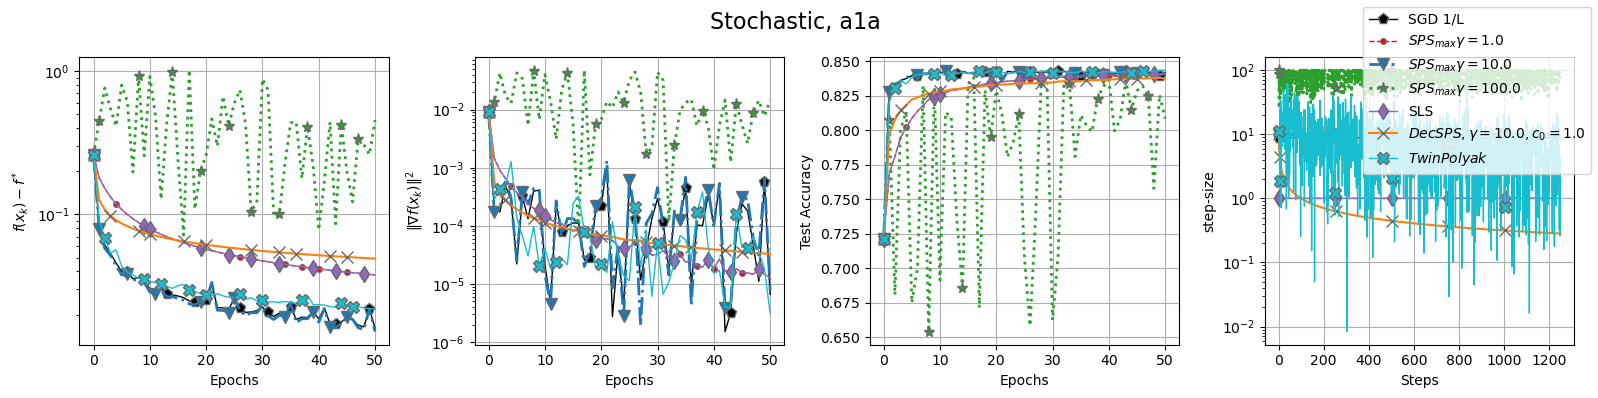

In [191]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.5, 1.0],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        suptitle=f"{setting}, {dataset_name}",
        prefix="train",
        threshold=0.0,
        apply_ma=False,
        # filename=f"rand_{dataset_name}_{setting.lower()}_logreg.pdf",
        )

In [ ]:
def twin_polyak_ma_WIP(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0,
               beta: float = 0.9,
               eps: float = 0.0,
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset

    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1])

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/acc"].append(acc)
    history["train/grad_norm_sq"].append(g_norm_sq)
    
    # Test Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    fm_x = 0.0
    gm_x = np.zeros_like(params_x)
    gamma_x = 0.0
    
    fm_y = 0.0
    gm_y = np.zeros_like(params_y)
    gamma_y = 0.0
    
    # batch_size = int(train_data.shape[0] * 0.9)
    
    step_t = 0
    
    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            loss_y, grad_y, acc_y  = loss_function.func_grad_acc(params_y, batch_data, batch_target)

            fm_x = beta * fm_x + (1 - beta) * loss_x
            gamma_x = beta * gamma_x + (1 - beta) * np.dot(grad_x, params_x)
            gm_x = beta * gm_x + (1 - beta) * grad_x
            h_x = fm_x + (np.dot(gm_x, params_x) - gamma_x)
            
            fm_y = beta * fm_y + (1 - beta) * loss_y
            gamma_y = beta * gamma_y + (1 - beta) * np.dot(grad_y, params_y)
            gm_y = beta * gm_y + (1 - beta) * grad_y
            h_y = fm_y + np.dot(gm_y, params_y) - gamma_y

            if h_x > h_y:
                diff = h_x - h_y
                lr_x = diff / (0.5 * np.square(np.linalg.norm(gm_x)) + eps) 
                params_x -= lr_x * gm_x
                lr = lr_x
                history["train/batch/loss"].append(loss_y)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_y)**2)
            else:
                diff = h_y - h_x
                lr_y = diff / (0.5 * np.square(np.linalg.norm(gm_y)) + eps)
                params_y -= lr_y * gm_y
                lr = lr_y
                history["train/batch/loss"].append(loss_x)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_x)**2)
            
            history["lr"].append(lr)
            
        # if (epoch + 1) % 20 == 0:
        #     batch_size = int(train_data.shape[0] * 0.1)
            
        # history["beta"].append(beta)
        # if (epoch + 1) % 20 == 0:
        #     if beta < 0.8:
        #         beta += 0.1
        #     else:
        #         beta = 0.9
        #     print(epoch, beta)
            
        # Train Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, train_data, train_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, train_data, train_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)
            
        # Test Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, test_data, test_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

In [277]:
n_epochs = 100
seed = 0

histories = []
labels = []
beta = 0.9

for eta_max in [1.0, 5.0, 10.0, 20.0]:
        hist_sps = train_loop(dataset=dataset,
                        batch_size=batch_size,
                        n_epochs=n_epochs,
                        optimizer=SPS_MA,
                        seed=seed,
                        betas=(beta, beta),
                        eta_max=eta_max,
                        )
        histories.append(hist_sps)
        labels.append(r"$SPS_{{max}} MA, \eta_{{max}}={0}, \beta={1}$".format(eta_max, beta))

beta = 0.9
lr = 1.0
eps = 0.0
hist_momo = train_loop(dataset=dataset,
                batch_size=batch_size,
                n_epochs=n_epochs,
                optimizer=SGD_Momo,
                seed=seed,
                beta=beta,
                lr=lr,
                eps=eps
                )
histories.append(hist_momo)
labels.append(r"Momo, $\gamma_{{min}}={0}, \beta={1}$".format(lr, beta))

eps = 1e-6
for beta in [0.0, 0.9]:
        hist_twin_ma = twin_polyak_ma(dataset=dataset,
                        batch_size=batch_size,
                        n_epochs=n_epochs,
                        beta=beta,
                        eps=eps)

        histories.append(hist_twin_ma)
        labels.append(r"STP MA, $\beta={0}$".format(beta))

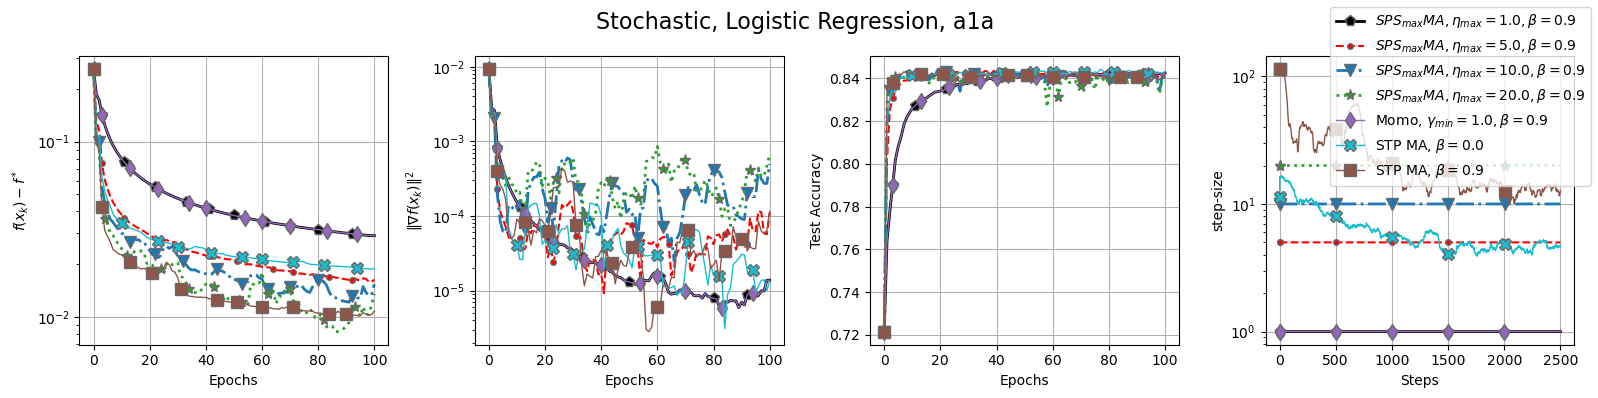

In [278]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:cyan", "tab:brown"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[2.0, 1.5, 2.0, 2.0, 1.0, 1.0, 1.0],
        markers=["p", ".", "v", "*", "d", "X", "s"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        suptitle=f"{setting}, Logistic Regression, {dataset_name}",
        prefix="train",
        threshold=0.0,
        # filename=f"momo-type-momentum_{dataset_name}.pdf",
        )